In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import numpy as np

# --- 1. DEFINE EXPERIMENTS ---
experiments = [
    {
        "name": "D1_G1 (Baseline)",
        "d_updates": 1,
        "g_updates": 1,
        "output_dir": "/kaggle/working/Q3_Experiment_D1_G1",
    },
    {
        "name": "D5_G1 (Discriminator Heavy)",
        "d_updates": 5,
        "g_updates": 1,
        "output_dir": "/kaggle/working/Q3_Experiment_D5_G1",
    },
    {
        "name": "D1_G3 (Generator Heavy)",
        "d_updates": 1,
        "g_updates": 4,
        "output_dir": "/kaggle/working/Q3_Experiment_D1_G3",
    },
]

In [2]:
# --- 2. GLOBAL CONFIGURATION ---
class Config:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 2
    dataset_path = '/kaggle/input/dgm-animals/Animals_data/animals/animals'
    image_size = 128
    img_channels = 3
    latent_dim = 100
    embedding_dim = 100
    features_g = 64
    features_d = 64
    batch_size = 64
    num_epochs = 30
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    label_smoothing = 0.1
    sample_interval = 10

# Instantiate the global config
config = Config()
print(f"Global configuration loaded. Using device: {config.device}")
print(f"Found {len(experiments)} experiments to run.")

Global configuration loaded. Using device: cuda
Found 3 experiments to run.


In [3]:
# --- 3. HELPER FUNCTIONS AND MODELS ---
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, embedding_dim, channels_img, features_g):
        super(ConditionalGenerator, self).__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            self._block(latent_dim + embedding_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            self._block(features_g * 2, features_g, 4, 2, 1),
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False), nn.BatchNorm2d(out_c), nn.ReLU(True))
    def forward(self, z, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([z, embedding], dim=1)
        return self.net(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embedding_dim, channels_img, features_d):
        super(ConditionalDiscriminator, self).__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)
        self.net = nn.Sequential(
            nn.Conv2d(channels_img + embedding_dim, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid())
    def _block(self, in_c, out_c, k, s, p):
        return nn.Sequential(nn.Conv2d(in_c, out_c, k, s, p, bias=False), nn.BatchNorm2d(out_c), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3))
    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], -1, 1, 1).expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, embedding], dim=1)
        return self.net(x).view(-1, 1).squeeze(1)

In [4]:
# --- MAIN EXPERIMENT RUNNER ---

# --- Prepare Data (do this once) ---
transform = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(root=config.dataset_path, transform=transform)
config.num_classes = len(dataset.classes)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
print(f"Dataset loaded with {len(dataset)} images in {config.num_classes} classes.")

# --- Loop through all experiments ---
for exp in experiments:
    print("\n" + "="*50)
    print(f"RUNNING EXPERIMENT: {exp['name']}")
    print("="*50)

    os.makedirs(exp['output_dir'], exist_ok=True)
    
    gen = ConditionalGenerator(config.latent_dim, config.num_classes, config.embedding_dim, config.img_channels, config.features_g).to(config.device)
    disc = ConditionalDiscriminator(config.num_classes, config.embedding_dim, config.img_channels, config.features_d).to(config.device)
    gen.apply(weights_init)
    disc.apply(weights_init)

    criterion = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))
    optimizerG = optim.Adam(gen.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))

    # Reset metrics for each experiment
    G_losses, D_losses, D_x_history, D_G_z_history = [], [], [], []
    fixed_noise = torch.randn(64, config.latent_dim, 1, 1, device=config.device)
    fixed_labels = torch.randint(0, config.num_classes, (64,), device=config.device)

    # --- Training Loop for this experiment ---
    for epoch in range(config.num_epochs):
        epoch_loss_d, epoch_loss_g = 0.0, 0.0
        # ADDED: Trackers for detailed metrics
        epoch_d_x, epoch_d_gz = 0.0, 0.0
        
        for i, (real_imgs, labels) in enumerate(dataloader):
            real_imgs, labels = real_imgs.to(config.device), labels.to(config.device)
            b_size = real_imgs.size(0)
            real_label = torch.full((b_size,), 1.0 - config.label_smoothing, device=config.device)
            fake_label = torch.full((b_size,), 0.0, device=config.device)
            
            # Train Discriminator
            for _ in range(exp['d_updates']):
                disc.zero_grad()
                with torch.no_grad():
                    noise = torch.randn(b_size, config.latent_dim, 1, 1, device=config.device)
                    fake_imgs = gen(noise, labels)
                
                output_real = disc(real_imgs, labels)
                lossD_real = criterion(output_real, real_label)
                # ADDED: Track D(x)
                epoch_d_x += output_real.mean().item()
                
                output_fake = disc(fake_imgs.detach(), labels)
                lossD_fake = criterion(output_fake, fake_label)
                # ADDED: Track D(G(z))
                epoch_d_gz += output_fake.mean().item()
                
                lossD = (lossD_real + lossD_fake) / 2
                lossD.backward()
                optimizerD.step()
                epoch_loss_d += lossD.item()

            # Train Generator
            for _ in range(exp['g_updates']):
                gen.zero_grad()
                noise = torch.randn(b_size, config.latent_dim, 1, 1, device=config.device)
                fake_imgs = gen(noise, labels)
                output_gen = disc(fake_imgs, labels)
                lossG = criterion(output_gen, real_label)
                lossG.backward()
                optimizerG.step()
                epoch_loss_g += lossG.item()
        
        # Calculate and store average metrics for the epoch
        num_batches = len(dataloader)
        avg_loss_d = epoch_loss_d / (num_batches * exp['d_updates'])
        avg_loss_g = epoch_loss_g / (num_batches * exp['g_updates'])
        avg_d_x = epoch_d_x / (num_batches * exp['d_updates'])
        avg_d_gz = epoch_d_gz / (num_batches * exp['d_updates'])
        
        D_losses.append(avg_loss_d)
        G_losses.append(avg_loss_g)
        D_x_history.append(avg_d_x)
        D_G_z_history.append(avg_d_gz)
        
        # CHANGED: Updated print statement to show more metrics
        print(f"[{exp['name']}] [Epoch {epoch+1}/{config.num_epochs}] Loss_D: {avg_loss_d:.4f} | Loss_G: {avg_loss_g:.4f} | D(x): {avg_d_x:.4f} | D(G(z)): {avg_d_gz:.4f}")

        if (epoch + 1) % config.sample_interval == 0 or epoch == config.num_epochs - 1:
            with torch.no_grad():
                gen.eval()
                samples = gen(fixed_noise, fixed_labels).detach().cpu()
                save_image(samples, os.path.join(exp['output_dir'], f"samples_epoch_{epoch+1:03d}.png"), normalize=True)
                gen.train()

    # --- ADDED: Save final models for this experiment ---
    torch.save(gen.state_dict(), os.path.join(exp['output_dir'], 'generator_final.pth'))
    torch.save(disc.state_dict(), os.path.join(exp['output_dir'], 'discriminator_final.pth'))
    print(f"--- Experiment {exp['name']} finished. Models saved. ---")

    # --- Save plot for this experiment ---
    plt.figure(figsize=(10, 5))
    plt.title(f"Loss Curves - {exp['name']}")
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Average Loss")
    plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(exp['output_dir'], "loss_curve.png"))
    plt.close()

print("\nAll experiments completed!")

Dataset loaded with 5376 images in 90 classes.

RUNNING EXPERIMENT: D1_G1 (Baseline)
[D1_G1 (Baseline)] [Epoch 1/30] Loss_D: 1.1728 | Loss_G: 1.1296 | D(x): 0.4252 | D(G(z)): 0.4785
[D1_G1 (Baseline)] [Epoch 2/30] Loss_D: 0.9963 | Loss_G: 1.0226 | D(x): 0.4323 | D(G(z)): 0.4681
[D1_G1 (Baseline)] [Epoch 3/30] Loss_D: 0.8635 | Loss_G: 0.9340 | D(x): 0.4375 | D(G(z)): 0.4618
[D1_G1 (Baseline)] [Epoch 4/30] Loss_D: 0.8362 | Loss_G: 0.9013 | D(x): 0.4434 | D(G(z)): 0.4594
[D1_G1 (Baseline)] [Epoch 5/30] Loss_D: 0.8008 | Loss_G: 0.8624 | D(x): 0.4466 | D(G(z)): 0.4573
[D1_G1 (Baseline)] [Epoch 6/30] Loss_D: 0.7943 | Loss_G: 0.8777 | D(x): 0.4471 | D(G(z)): 0.4519
[D1_G1 (Baseline)] [Epoch 7/30] Loss_D: 0.7750 | Loss_G: 0.8580 | D(x): 0.4506 | D(G(z)): 0.4529
[D1_G1 (Baseline)] [Epoch 8/30] Loss_D: 0.7636 | Loss_G: 0.8587 | D(x): 0.4499 | D(G(z)): 0.4514
[D1_G1 (Baseline)] [Epoch 9/30] Loss_D: 0.7759 | Loss_G: 0.8668 | D(x): 0.4482 | D(G(z)): 0.4525
[D1_G1 (Baseline)] [Epoch 10/30] Loss_D: 0

Generating comparison plot...


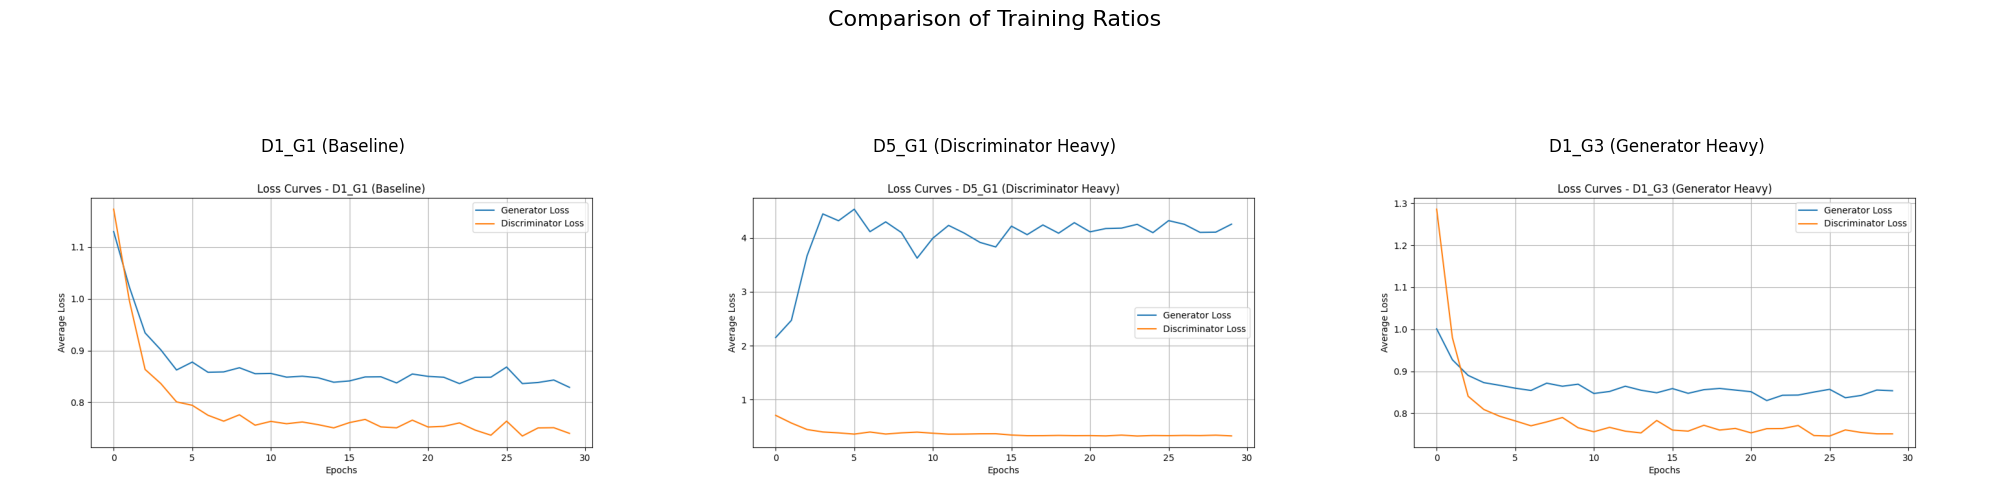


Comparison complete. Check the 'Output' section on Kaggle for all saved images and plots.


In [5]:
# --- FINAL VISUALIZATION ---
print("Generating comparison plot...")

fig, axes = plt.subplots(1, len(experiments), figsize=(20, 6))
plt.suptitle("Comparison of Training Ratios", fontsize=16)

for i, exp in enumerate(experiments):
    plot_path = os.path.join(exp['output_dir'], "loss_curve.png")
    if os.path.exists(plot_path):
        img = plt.imread(plot_path)
        axes[i].imshow(img)
        axes[i].set_title(exp['name'])
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'Plot not found', ha='center', va='center')
        axes[i].set_title(exp['name'])
        axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("/kaggle/working/experiment_comparison.png")
plt.show()

print("\nComparison complete. Check the 'Output' section on Kaggle for all saved images and plots.")